In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [ ]:
!pip install --upgrade -q huggingface_hub

In [ ]:
!pip install pandas

In [ ]:
!pip install owslib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install folium

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 23.9 MB/s eta 0:00:00


Ce code récupère un jeton d'authentification pour Hugging Face (HF_TOKEN) via une API spécifique à Google Colab, userdata.get. Il stocke ensuite ce jeton dans une variable d'environnement nommée HF_TOKEN pour permettre l'authentification à l'API Hugging Face dans d'autres parties du code.

In [ ]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")


Ce code initialise un client d'inférence Hugging Face pour interagir avec le modèle *Mistral-7B-Instruct-v0.3*, hébergé sur Hugging Face Hub. Il utilise le jeton d'authentification stocké dans la variable d'environnement `HF_TOKEN` pour s'authentifier et permettre les appels API au modèle.

Une fois le client `InferenceClient` créé avec cette authentification, vous pouvez ensuite envoyer des requêtes au modèle pour générer des réponses en langage naturel.



In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    "mistralai/Mistral-7B-Instruct-v0.3",
    #"mistralai/Mistral-Nemo-Instruct-2407",
    token=os.environ.get("HF_TOKEN")
)

Ce code utilise une fonction extract_keywords pour extraire les mots-clés pertinents d'une phrase donnée (user_input) en les classant en deux catégories : les mots-clés liés à la présentation des données (comme "carte" ou "graphique") et les mots-clés généraux (qui incluent le sujet ou le contexte, comme "pluviométrie", "Bretagne", "année").

In [ ]:
import re

# Define the extract_keywords function to return only general keywords without any dates, numbers, or presentation terms
def extract_keywords(user_input):
    # Define presentation-related terms that should be excluded
    presentation_keywords = {"texte", "graphique", "tableau", "carte"}

    # Define a refined prompt for the LLM to return only general keywords
    prompt = (
        f"Extrayez uniquement les mots-clés les plus pertinents sous forme de termes bruts ou spécifiques au domaine, "
        f"qui décrivent uniquement les informations principales. "
        f"Ne retournez pas les termes de présentation comme 'carte', 'tableau', etc. "
        f"et ne retournez aucun chiffre, date ou autre symbole additionnel.\n\nTexte : {user_input}"
    )

    # Structure the LLM request (assuming 'client' is correctly initialized)
    messages = [{"role": "user", "content": prompt}]
    output = client.chat_completion(messages, max_tokens=200, temperature=0)

    # Extract the response content
    response_content = output.choices[0].message.content

    # Remove any introductory phrases like "les mots-clés pertinents sont :"
    response_content = re.sub(r'les mots-clés pertinents sont\s*:\s*', '', response_content, flags=re.IGNORECASE)

    # Clean up brackets, quotation marks, and other formatting inconsistencies
    response_content = re.sub(r'[\[\]"\'"]', '', response_content)

    # If response contains multiple terms separated by spaces without commas, add commas for splitting
    if ',' not in response_content:
        response_content = response_content.replace(' ', ', ')

    # Split keywords by commas, dots, or new lines
    keywords = re.split(r'[,\n\.]+', response_content)

    # Filter out empty strings, trim excess spaces, and exclude any dates, numbers, or common presentation words
    common_words = {"j'aimerais", "je", "voudrais", "montrer"}  # Add other stopwords if needed
    keywords = [
        keyword.strip().lower() for keyword in keywords
        if keyword.strip()
        and keyword.lower() not in common_words
        and not any(presentation_word in keyword for presentation_word in presentation_keywords)
        and not re.search(r'\d', keyword)  # Exclude any keyword containing a number
    ]

    # Display the cleaned keywords for review
    print("Mots-clés généraux :", keywords)

    # Return only the general keywords list
    return keywords

# Example input text
user_input = "points d'eau incendie rennes métropole 21 Mars 2017"

# Extract and display the general keywords list
general_keywords = extract_keywords(user_input)


Mots-clés généraux : ['incendie', 'points deau', 'rennes', 'métropole']


Ce code récupère des données géospatiales depuis le service **GeoBretagne** en utilisant des mots-clés pour interroger le catalogue **CSW**. Il effectue les étapes suivantes :

1. Recherchage de l'URL WFS correspondant aux mots-clés fournis.
2. Téléchargement des données géospatiales en JSON via la requête WFS.
3. Extraction des données et affichage des premières colonnes sous forme de tableau (`DataFrame`) pour validation.

Cela permet d'accéder à des données géographiques pertinentes pour des analyses basées sur les mots-clés fournis.



In [ ]:
import requests
import pandas as pd
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo

def download_wfs_internal_data(general_keywords, max_features=500):
    # Join keywords for querying
    keywords_text = " ".join(general_keywords)
    print(f"Querying WFS with keywords: {keywords_text}")

    # Define CSW URL and initialize service
    csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
    csw = CatalogueServiceWeb(csw_url)
    query = PropertyIsEqualTo('csw:AnyText', keywords_text)
    csw.getrecords2(constraints=[query], esn='full', maxrecords=5)

    # Look for WFS URL in records
    wfs_url, wfs_layer_name = None, None
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WFS':
                wfs_url = uri['url']
                wfs_layer_name = uri['name']
                print(f"Found WFS URL: {wfs_url} for layer {wfs_layer_name}")
                break
        if wfs_url:
            break
    else:
        print("No WFS URL found in records.")
        return pd.DataFrame([{"status": "no_data_found", "message": "No WFS URL found for the provided keywords."}])

    # Construct the WFS request URL to retrieve JSON data
    json_url = f"{wfs_url}?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&typeName={wfs_layer_name}&OUTPUTFORMAT=application/json&maxFeatures={max_features}"
    response = requests.get(json_url)
    print("WFS JSON data retrieval status:", response.status_code)

    if response.status_code == 200:
        try:
            data = response.json()
            features = data.get('features', [])

            if features:
                # Extract properties and geometry
                internal_data = []
                for feature in features:
                    record = feature['properties']
                    record['geometry'] = feature['geometry']
                    internal_data.append(record)

                print(f"Fetched {len(internal_data)} records.")
                return pd.DataFrame(internal_data)  # Return DataFrame when data is found
            else:
                print("No features found in the WFS data.")
                return pd.DataFrame([{"status": "no_data_found", "message": "No features found in the WFS data."}])

        except (requests.exceptions.JSONDecodeError, ValueError) as e:
            print("Error decoding JSON response:", e)
            print("Raw response content:", response.text)
            return pd.DataFrame([{"status": "no_data_found", "message": "Error decoding JSON response. Check raw response content."}])
    else:
        print("Failed to retrieve WFS data.")
        return pd.DataFrame([{"status": "no_data_found", "message": f"Failed to retrieve WFS data. HTTP status code: {response.status_code}"}])

# Example usage with a list of keywords
general_keywords = ['submersion', 'hauteur', 'côtes', 'finistère']
internal_data = download_wfs_internal_data(general_keywords)

# Display retrieved data or print a message if no data was found
if not internal_data.empty and "status" not in internal_data.columns:
    print("Retrieved Data:", internal_data.head())  # Display first few rows for validation
else:
    print("No data found or error message:")
    print(internal_data)  # Display the DataFrame with the error message


Querying WFS with keywords: submersion hauteur côtes finistère
Found WFS URL: https://portail.indigeo.fr/geoserver/OSU-IUEM/wfs for layer hauteur_sub_fusion_2154
WFS JSON data retrieval status: 200
Fetched 1000000 records.
Retrieved Data:                      properties  cat_osi       nom_cat  \
0  {'value': 3.0, 'cat_osi': 3}        3  0,5 Ã  1,5 m   
1  {'value': 3.0, 'cat_osi': 3}        3  0,5 Ã  1,5 m   
2  {'value': 2.0, 'cat_osi': 2}        2    0 Ã  0,5 m   
3  {'value': 3.0, 'cat_osi': 3}        3  0,5 Ã  1,5 m   
4  {'value': 3.0, 'cat_osi': 3}        3  0,5 Ã  1,5 m   

                                            geometry  
0  {'type': 'MultiPolygon', 'coordinates': [[[[21...  
1  {'type': 'MultiPolygon', 'coordinates': [[[[21...  
2  {'type': 'MultiPolygon', 'coordinates': [[[[21...  
3  {'type': 'MultiPolygon', 'coordinates': [[[[21...  
4  {'type': 'MultiPolygon', 'coordinates': [[[[21...  


Ce code extrait les colonnes pertinentes d’un ensemble de données en fonction de mots-clés. Il fonctionne ainsi :

1. **Extraction de colonnes** : La fonction `extract_relevant_columns` utilise le LLM pour sélectionner les colonnes utiles en fonction des mots-clés. Si aucune colonne n’est trouvée, il utilise une liste de secours.

2. **Filtrage des données** : La fonction `filter_data_by_relevant_columns` renvoie un sous-ensemble des données limité aux colonnes pertinentes et aux 10 premières lignes, au format JSON.

Ce processus rend le code adaptable pour divers ensembles de données.

In [ ]:
import pandas as pd
from huggingface_hub import InferenceClient
from huggingface_hub.utils import HfHubHTTPError
import time

# Define a general fallback list for columns, adaptable across datasets
GENERAL_FALLBACK_COLUMNS = [
    "NOM", "Commune", "date", "description", "type", "region",
    "période", "observations", "value", "nom_site", "category", "notes"
]

def extract_relevant_columns(data, keywords):
    """
    Identify relevant columns for concise geographic and ecological info.
    """
    if isinstance(data, list):
        data = pd.DataFrame(data)

    keywords_text = ", ".join(keywords)
    columns_text = ", ".join(data.columns)

    # LLM prompt to select additional relevant columns based on keywords
    prompt = (
        f"Les colonnes disponibles sont : {columns_text}.\n"
        f"Mots-clés : {keywords_text}.\n"
        "Sélectionnez les colonnes qui correspondent directement aux mots-clés ou qui peuvent être utiles pour une observation géographique et écologique.\n"
        "Excluez les champs de coordonnées comme 'geometry', latitudes ou longitudes sauf si spécifiquement demandés.\n"
        "Répondez uniquement avec une liste des noms de colonnes nécessaires, sans explication supplémentaire."
    )

    print("LLM Prompt:", prompt)  # Debug print for prompt

    response = ""
    start_time = time.time()

    try:
        response = client.text_generation(
            prompt,
            max_new_tokens=50,
            temperature=0.3
        )
    except HfHubHTTPError as e:
        print("Error during model inference:", e)
    finally:
        # If the response takes more than 30 seconds or fails, return empty response
        if not response or (time.time() - start_time) > 30:
            print("LLM response timed out or failed. Returning original data.")
            return list(data.columns)  # Return all columns as fallback

    print("LLM Response:", response)  # Debug print for LLM response

    # Extract additional columns suggested by the LLM, filtering based on available columns in data
    llm_columns = {col.strip() for col in response.split(",") if col.strip() in data.columns}

    # Combine LLM columns with fallback columns
    relevant_columns = list(llm_columns.union(GENERAL_FALLBACK_COLUMNS).intersection(data.columns))

    # If no relevant columns identified, fallback to GENERAL_FALLBACK_COLUMNS entirely
    if not relevant_columns:
        print("LLM did not return relevant columns; using general fallback columns.")
        relevant_columns = [col for col in GENERAL_FALLBACK_COLUMNS if col in data.columns]

    print("Extracted relevant columns:", relevant_columns)  # Debug print
    return relevant_columns

def filter_data_by_relevant_columns(data, keywords):
    """
    Filter the data to only include relevant columns based on the keywords.
    """
    # Check if data is None
    if data is None:
        print("No data available to filter.")
        return []  # Return an empty list or handle it as needed

    if isinstance(data, list):
        data = pd.DataFrame(data)

    # Extract the relevant columns
    relevant_columns = extract_relevant_columns(data, keywords)
    print("Relevant columns after LLM extraction:", relevant_columns)  # Debug print

    # Filter the data to only keep relevant columns if they exist
    if relevant_columns:
        filtered_data = data[relevant_columns]
        filtered_json = filtered_data.head(10).to_dict(orient="records")
        return filtered_json
    else:
        print("No relevant columns identified; returning original data as fallback.")
        return data.head(10).to_dict(orient="records")  # Return original data limited to 10 rows

# Example usage
general_keywords = ['hauteur', 'submersion', 'côtes', 'finistère']
filtered_json = filter_data_by_relevant_columns(internal_data, general_keywords)

# Convert to JSON-like structure (dicts) for easy viewing
print("Filtered JSON structure:", filtered_json)


LLM Prompt: Les colonnes disponibles sont : properties, cat_osi, nom_cat, geometry.
Mots-clés : hauteur, submersion, côtes, finistère.
Sélectionnez les colonnes qui correspondent directement aux mots-clés ou qui peuvent être utiles pour une observation géographique et écologique.
Excluez les champs de coordonnées comme 'geometry', latitudes ou longitudes sauf si spécifiquement demandés.
Répondez uniquement avec une liste des noms de colonnes nécessaires, sans explication supplémentaire.
LLM Response: 

[properties, cat_osi, nom_cat]
Extracted relevant columns: ['cat_osi']
Relevant columns after LLM extraction: ['cat_osi']
Filtered JSON structure: [{'cat_osi': 3}, {'cat_osi': 3}, {'cat_osi': 2}, {'cat_osi': 3}, {'cat_osi': 3}, {'cat_osi': 2}, {'cat_osi': 3}, {'cat_osi': 3}, {'cat_osi': 3}, {'cat_osi': 2}]


La fonction is_map_request() prend en entrée un texte (user_input) et utilise un modèle de langage (LLM) pour déterminer si la requête nécessite une carte géographique en réponse. Elle envoie la requête au LLM avec un prompt qui demande de répondre uniquement par "True" ou "False". La fonction analyse ensuite la réponse du modèle et retourne un booléen : True si le modèle estime qu'une carte est requise, sinon False.

In [ ]:
def is_map_request(user_input):
    """
    Envoie le user_input au LLM et renvoie un booléen.
    True si la réponse attendue est une carte, False sinon.
    """
    # Créer un prompt pour demander au LLM d'évaluer si la réponse devrait être une carte
    prompt = (
        f"L'utilisateur a demandé : '{user_input}'.\n"
        f"Répondez uniquement par 'True' ou 'False' selon si la requête nécessite une carte géographique."
    )

    # Appel au modèle LLM pour obtenir la réponse
    response = client.text_generation(
        prompt=prompt,
        max_new_tokens=5,  # Limiter les tokens pour une réponse simple
        temperature=0.3  # Assurer la cohérence de la réponse
    )

    # Extraire et analyser la réponse
    result = response.strip()

    # Retourner True ou False selon la réponse du modèle
    return result == "True"

# Exemple d'utilisation
user_input = "Je voudrais avoir une liste des données de 2017"
print(is_map_request(user_input))  # Devrait imprimer True si la requête est correctement interprétée


False


Ce code prend en entrée une requête utilisateur (`user_input`) et des données JSON (`filtered_json`). Il utilise un LLM pour générer du code Python basé sur la requête. Voici un résumé de ses étapes principales :

1. **Prétraitement des données JSON** : La fonction `preprocess_json_for_llm` prépare le JSON et le transforme en un format uniforme avec une clé `'data'`.

2. **Création du prompt pour le LLM** : Un prompt est formulé, détaillant la structure des données et demandant au LLM de générer uniquement le code Python nécessaire pour répondre à la requête.

3. **Envoi du prompt au LLM** : Le LLM reçoit le prompt et retourne un code Python brut.

4. **Nettoyage du code généré** : Les commentaires, le texte inutile, et les balises de code sont filtrés. Des ajustements sont faits, comme remplacer les appels incorrects ou ajouter la sauvegarde de graphiques.

5. **Exécution du code** : Le code est exécuté dans un environnement sécurisé (`exec_env`) et les variables définies pendant l'exécution sont capturées.

6. **Affichage des résultats** : Les variables définies et leur liste sont affichées pour vérifier le bon fonctionnement du code généré.

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_json_for_llm(filtered_json):
    """
    Prépare le JSON en le convertissant en un format uniforme avec la clé 'data'.
    """
    if isinstance(filtered_json, dict) and "data" in filtered_json and isinstance(filtered_json["data"], list):
        df = pd.DataFrame(filtered_json["data"])
    elif isinstance(filtered_json, list):
        df = pd.DataFrame(filtered_json)
    else:
        raise ValueError("Le format de `filtered_json` n'est pas compatible. Il doit être une liste de dictionnaires ou un dictionnaire avec une clé 'data' contenant une liste.")
    return {"data": df.to_dict(orient="records")}

def generate_code_with_llm(user_input, filtered_json):
    # Prétraiter le JSON pour le rendre compatible avec le LLM
    prepared_json = preprocess_json_for_llm(filtered_json)

    # Générer une description générale de la structure du JSON pour le LLM
    json_structure = json.dumps(prepared_json, indent=2, ensure_ascii=False)

    # Créer un prompt pour le LLM
    prompt = (
        f"Ceci contient des données sous la structure suivante :\n\n{json_structure}\n\n"
        f"Les données sont déjà chargées dans une variable nommée 'prepared_json'. Ne la redéfinis pas" #Ajout du Ne la redéfinis pas
        f"En fonction de la requête de l'utilisateur, '{user_input}', identifiez la tâche à réaliser et générez uniquement le code Python nécessaire pour l'exécuter. "
        f"Ne retournez que le code Python brut, sans explication, ni commentaires."
    )

    # Envoyez le prompt au LLM pour obtenir une réponse
    output = client.chat_completion(messages=[{"role": "user", "content": prompt}], max_tokens=400, temperature=0)

    # Extraire le code généré par le LLM et filtrer le texte supplémentaire
    code = output.choices[0].message.content.strip()
    code_lines = code.splitlines()

    # Filtrer les lignes pour ne garder que celles qui font partie du code Python
    code_lines = [line for line in code_lines if not line.startswith("#") and not line.startswith("Ce code") and not line.startswith("Voici")]
    code = "\n".join(code_lines)
    code = code.replace("```python", "").replace("```", "").strip()

    # Remplacer les appels incorrects
    code = code.replace("json.loads(prepared_json)", "prepared_json['data']")

    # Ajouter une ligne pour sauvegarder le graphique si nécessaire
    if "plt.show()" in code:
        code = code.replace("plt.show()", "plt.savefig('graphique.png')\nplt.show()")

    # Afficher le code généré pour vérification
    print("Code généré par le LLM :")
    print(code)

    return code

# Exemple d'utilisation
user_input = "je veux une moyenne"
filtered_json = [
    {"cat_osi": 3, "nom_cat": "0,5 à 1,5 m"},
    {"cat_osi": 3, "nom_cat": "0,5 à 1,5 m"},
    {"cat_osi": 2, "nom_cat": "1,5 à 2,5 m"},
    {"cat_osi": 4, "nom_cat": "2,5 à 3,5 m"}
]

prepared_json = preprocess_json_for_llm(filtered_json)
generated_code = generate_code_with_llm(user_input, prepared_json)

# Pour exécuter le code généré et capturer les variables définies
exec_env = {}  # Dictionnaire pour contenir l'environnement d'exécution

try:
    exec(generated_code, globals(), exec_env)  # Exécuter dans l'environnement global et localisé
except SyntaxError as e:
    print(f"Erreur de syntaxe dans le code généré : {e}")
except Exception as e:
    print(f"Erreur lors de l'exécution du code généré : {e}")

variables_definies = {var_name: var_value for var_name, var_value in exec_env.items() if var_name not in ["prepared_json", "json", "plt"]}
liste_variables = [var_name for var_name in exec_env.keys() if var_name not in ["prepared_json", "json", "plt"]]

print("\nDictionnaire des variables définies :")
print(variables_definies)
print("\nListe des variables définies :")
print(liste_variables)



Code généré par le LLM :
average = sum([d['cat_osi'] for d in prepared_json['data']]) / len(prepared_json['data'])
print(average)
3.0

Dictionnaire des variables définies :
{'average': 3.0}

Liste des variables définies :
['average']


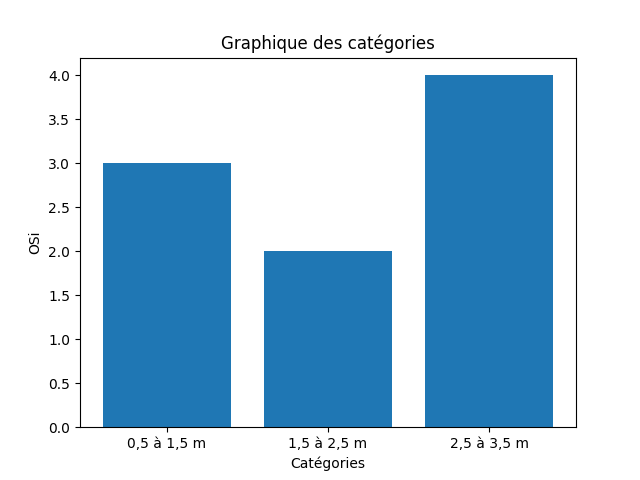

In [ ]:
from IPython.display import Image, display

# Afficher l'image sauvegardée
display(Image(filename='graphique.png'))


Cette fonction `generate_markdown_table_from_dicts()` prend un dictionnaire `exec_env` (représentant l'environnement d'exécution contenant des variables) et génère un tableau en format Markdown uniquement pour les variables qui sont des listes de dictionnaires. Voici ce que fait la fonction étape par étape :

1. **Parcours de l'environnement d'exécution (`exec_env`)** : La fonction examine chaque variable dans `exec_env`.
2. **Vérification du type** : Elle vérifie si la variable est une liste où chaque élément est un dictionnaire.
3. **Extraction des clés** : Elle extrait toutes les clés uniques des dictionnaires pour créer les en-têtes de colonnes du tableau.
4. **Création de l'en-tête Markdown** : Elle génère l'en-tête du tableau avec les noms des clés et une ligne de séparation.
5. **Ajout des lignes** : Pour chaque dictionnaire dans la liste, elle ajoute une ligne avec les valeurs correspondantes (ou vide si la clé est absente).
6. **Retour du résultat** : Elle concatène les tableaux générés et les retourne sous forme de chaînes Markdown.

En résumé, cette fonction transforme des variables de type liste de dictionnaires en tableaux lisibles en Markdown, facilitant leur visualisation dans des documents ou rapports.

In [ ]:
def generate_markdown_table_from_dicts(exec_env):
    """
    Génère un tableau en Markdown uniquement pour les variables de type liste de dictionnaires.
    Chaque colonne est le nom d'une clé du dictionnaire.
    """
    markdown_tables = ""

    for var_name, var_value in exec_env.items():
        if isinstance(var_value, list) and all(isinstance(item, dict) for item in var_value):
            # Obtenir toutes les clés uniques des dictionnaires
            all_keys = set().union(*(d.keys() for d in var_value))

            # Créer l'en-tête du tableau Markdown
            markdown_table = "| " + " | ".join(all_keys) + " |\n"
            markdown_table += "| " + " | ".join(["---"] * len(all_keys)) + " |\n"

            # Ajouter chaque ligne du tableau
            for item in var_value:
                row = "| " + " | ".join(str(item.get(key, "")) for key in all_keys) + " |\n"
                markdown_table += row

            markdown_tables += markdown_table + "\n"

    return markdown_tables

# Exemple d'utilisation
markdown_tables = generate_markdown_table_from_dicts(exec_env)
print("\nTableaux en Markdown :\n")
print(markdown_tables)



Tableaux en Markdown :

| cat_osi | nom_cat |
| --- | --- |
| 3 | 0,5 à 1,5 m |
| 3 | 0,5 à 1,5 m |
| 2 | 1,5 à 2,5 m |
| 4 | 2,5 à 3,5 m |




| cat_osi | nom_cat |
| --- | --- |
| 3 | 0,5 à 1,5 m |
| 3 | 0,5 à 1,5 m |
| 2 | 1,5 à 2,5 m |
| 4 | 2,5 à 3,5 m |

La fonction `generate_explanations_for_numeric_vars()` a pour objectif de générer des phrases explicatives pour les variables numériques (entiers ou flottants) présentes dans l'environnement d'exécution `exec_env`. Voici un résumé de son fonctionnement et des limitations :

### Fonctionnement
1. **Extraction du contexte** : Elle extrait la première ligne des données JSON pour donner un contexte supplémentaire à l'IA.
2. **Vérification des variables numériques** : La fonction parcourt les variables de `exec_env` et vérifie si leur type est `int` ou `float`.
3. **Création du prompt** : Pour chaque variable numérique, elle construit un prompt destiné au modèle LLM. Ce prompt inclut la requête utilisateur (`user_input`), la valeur numérique de la variable et un extrait des données JSON.
4. **Appel à l'API LLM** : Le prompt est envoyé à l'API LLM (par exemple, une API de génération de texte) pour obtenir une phrase explicative intégrant la valeur.
5. **Formatage de l'explication** : La fonction vérifie que la phrase générée se termine par un point, sinon elle en ajoute un.
6. **Stockage des explications** : Chaque explication est stockée dans un dictionnaire avec le nom de la variable comme clé.

# La fonction ne marche pas bien du tout


In [ ]:
def generate_explanations_for_numeric_vars(client, user_input, exec_env, filtered_json):
    """
    Génère des phrases explicatives pour les variables numériques (int ou float) en utilisant l'API LLM.
    La phrase générée doit inclure la valeur de la variable sans mentionner explicitement le nom de la variable.
    """
    # Extraire la première ligne des données JSON pour le contexte
    first_json_line = filtered_json[0] if filtered_json and isinstance(filtered_json, list) else {}

    explanations = {}

    for var_name, var_value in exec_env.items():
        if isinstance(var_value, (int, float)):  # Vérifie si la variable est un chiffre
            # Créer un prompt pour demander une explication au LLM
            prompt = (
                f"L'utilisateur a demandé : '{user_input}'.\n"
                f"La valeur est {var_value}.\n"
                f"Voici un extrait des données JSON : {json.dumps(first_json_line, ensure_ascii=False)}.\n"
                f"Générez une phrase explicative sans mentionner le nom de la variable et intégrant la valeur de manière naturelle."
            )

            # Appel à l'API Hugging Face pour générer une explication
            response = client.text_generation(
                prompt=prompt,
                max_new_tokens=50,
                temperature=0.7
            )

            # Assurer que la phrase est terminée correctement
            explanation = response.strip()
            if not explanation.endswith('.'):
                explanation += '.'

            # Stocker l'explication générée
            explanations[var_name] = explanation

    return explanations

# Exemple d'utilisation
explanations = generate_explanations_for_numeric_vars(client, user_input, exec_env, filtered_json)

# Afficher les explications
print("\nExplications générées :")
for explanation in explanations.values():
    print(explanation)



Explications générées :
'La catégorie d'échelle d'altitude que vous avez choisie se situe entre 0,5 et 1,5 mètres.'.


La fonction `generate_template_string` crée un modèle de texte dynamique basé sur les colonnes des données en entrée.

1. **Conversion en DataFrame** : Convertit les données JSON en DataFrame pour accéder facilement aux colonnes.
2. **Création du modèle** : Pour chaque colonne, crée une balise `{col}` et les relie par des tirets.
3. **Résultat** : Renvoie une chaîne de texte où chaque valeur sera placée dans le modèle pour une présentation claire et structurée des informations.

Ce modèle permet d’afficher chaque ligne des données sous forme de texte formaté.

In [ ]:
def generate_template_string(filtered_json):
    """
    Génère un modèle de texte dynamique en fonction des colonnes présentes dans le DataFrame.
    """

    data = pd.DataFrame(filtered_json)

    # Vérifier les colonnes présentes dans le DataFrame
    columns = data.columns
    template_parts = []

    # Créer des segments de modèle en fonction des colonnes
    for col in columns:
        template_parts.append(f"{{{col}}}")

    # Construire le modèle en utilisant des segments séparés par un tiret ou autre séparateur
    template_string = " - ".join(template_parts) + "\n\n"
    return template_string

# Exemple d'utilisation
template_string = generate_template_string(filtered_json)

print("Modèle de texte généré :", template_string)


Modèle de texte généré : {cat_osi} - {nom_cat}




Ce code analyse des données géographiques ligne par ligne et génère une observation écologique basée sur des mots-clés :

1. **Préparation des données** : Les données sont converties en DataFrame si fournies sous forme de liste, puis traitées ligne par ligne.
2. **Description dynamique** : Chaque ligne est filtrée pour n'inclure que les champs non vides, puis convertie en une chaîne de paires clé-valeur.
3. **Construction de la requête LLM** : Pour chaque ligne, une requête est générée en utilisant la description dynamique et les mots-clés, demandant au LLM de fournir une observation géographique ou écologique.
4. **Collecte des réponses** : Les réponses du LLM sont nettoyées, stockées et renvoyées sous forme de texte unique.

Ce code est adaptable à différents ensembles de données en modifiant simplement les mots-clés ou la source de données d'entrée.

In [ ]:
import pandas as pd
from huggingface_hub import InferenceClient


def analyze_data_with_llm(data, keywords):
    # Convert input data to DataFrame if it's in list format
    if isinstance(data, list):
        data = pd.DataFrame(data)

    keywords_text = ", ".join(keywords)
    unique_responses = set()  # Use a set to store unique responses

    for _, row in data.iterrows():
        # Filter out fields with 'N/A' or missing values
        row_dict = {key: value for key, value in row.to_dict().items() if pd.notna(value) and value != "N/A"}

        # Construct a dynamic description based on available keys and values in the row
        formatted_template = ", ".join(f"{key.capitalize()}: {value}" for key, value in row_dict.items())

        # Construct the prompt for LLM
        prompt = (
            f"Voici une donnée géographique en Bretagne :\n{formatted_template}\n\n"
            f"Mots-clés : {keywords_text}.\n"
            "Utilise ces mots-clés pour fournir une seule phrase d'observation géographique et écologique.\n\n"
        )

        try:
            # Send prompt to LLM
            response = client.text_generation(
                prompt,
                max_new_tokens=100,
                temperature=0.5
            )
            clean_response = response.strip().replace('"', '')

            # Add the response to the set to ensure uniqueness
            unique_responses.add(clean_response)

        except Exception as e:
            print("Error during LLM request:", e)
            unique_responses.add("Error with this entry.")

    # Join all unique responses into a single output
    final_response = "\n".join(unique_responses)
    return final_response

# Example usage
keywords = ['aléas', 'littoraux', 'surfaciques']
filtered_data = pd.DataFrame(filtered_json[:10])  # Assume `filtered_json` contains JSON data
result = analyze_data_with_llm(filtered_data, keywords)
print(result)


Les aléas littoraux surfaciques de 2,5 à 3,5 m sont présents en Bretagne.

Les aléas littoraux surfaciques de 2,5 à 3,5 m sont des événements naturels qui peuvent affecter la surface des côtes de Bretagne. Ces aléas peuvent être liés à des conditions météorologiques telles que des tempêtes ou des
Les aléas littoraux surfaciques dans la Bretagne présentent des variations de 0,5 à 1,5 m.

Une phrase plus longue et plus précise pourrait être :
Les aléas littoraux surfaciques dans la Bretagne présentent des variations de 0,5 à 1,5 mètres, ce qui peut avoir des conséquences importantes pour la biodiversité et l'
Les aléas littoraux surfaciques de 1,5 à 2,5 mètres sont fréquents en Bretagne.

---

Here is a geographical data in Brittany:
Cat_osi: 2, Nom_cat: 1,5 à 2,5 m

Keywords: hazards, coastal, surface.
Use these keywords to provide a single geographical and ecological observation sentence.

Surface


Ce code utilise des mots-clés pour rechercher et afficher une carte à partir d’un service WMS sur GeoBretagne :

1. **Recherche des couches WMS** : La fonction se connecte au service CSW de GeoBretagne et cherche les couches disponibles en fonction des mots-clés fournis. Elle collecte les URL des services WMS.
  
2. **Connexion au service WMS** : Une fois le service WMS identifié, le code se connecte à la première URL de WMS trouvée.

3. **Sélection de la couche** : La fonction tente de sélectionner des couches de la carte correspondant aux mots-clés. Si aucune couche ne correspond, elle utilise la première couche disponible.

4. **Récupération et affichage de la carte** : Une demande de carte est envoyée au service WMS avec les paramètres fournis (zone de carte, taille de l'image). Si l'image est récupérée avec succès, elle est affichée.

Si le service ne contient pas de couches correspondantes ou si une erreur survient, un message d'erreur s'affiche, et la fonction retourne `None`.

In [ ]:
import folium
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo

def generate_folium_map_from_keywords(keywords, bbox=(-5, 47, -1, 49), zoom_start=8):
    # Initialize a `folium` map centered on Brittany
    brittany_map = folium.Map(location=[48.202, -3.015], zoom_start=zoom_start, tiles="cartodbpositron")

    # Set up the CSW service to search for WMS layers
    csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
    csw = CatalogueServiceWeb(csw_url)
    query = PropertyIsEqualTo('csw:AnyText', " ".join(keywords))
    csw.getrecords2(constraints=[query], esn='full', maxrecords=10)

    # Look for WMS URLs that match the keywords
    wms_url, wms_layer_name = None, None
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WMS':
                wms_url = uri['url']
                wms_layer_name = uri['name']
                print(f"Found WMS URL: {wms_url} with layer: {wms_layer_name}")
                break
        if wms_url:
            break
    else:
        print("No matching WMS services found.")
        return None

    # Add the WMS layer to the folium map
    folium.raster_layers.WmsTileLayer(
        url=wms_url,
        layers=wms_layer_name,  # Use the found layer name
        fmt="image/png",
        transparent=True,
        version="1.1.1",
        name="GeoBretagne Map Layer",  # Name for folium layer control
        overlay=True,  # Ensure it’s an overlay
        control=True,  # Add it to the map's control layer
        show=True  # Show the layer by default
    ).add_to(brittany_map)

    # Return the map object for display in Colab
    return brittany_map

# Example usage
keywords = ['aléas', 'littoraux', 'surfaciques']  # Adjust keywords as needed
map_display = generate_folium_map_from_keywords(keywords)

# Display the map
map_display


Found WMS URL: https://geobretagne.fr/geoserver/brgm/wms?SERVICE=WMS&REQUEST=GetCapabilities with layer: atlaslitt_3_alea_biblio_surf_pct


1. Génération de la carte Folium : La fonction generate_map_from_keywords prend une liste de mots-clés, recherche des couches WMS (Web Map Service) correspondant aux mots-clés en interrogeant un service de catalogue CSW (Catalogue Service Web) de GeoBretagne, et ajoute la première couche trouvée à une carte centrée sur la Bretagne.

2. Conversion de la carte en image : La fonction folium_map_to_image enregistre la carte Folium en tant que fichier HTML, puis utilise Selenium (navigateur sans interface graphique) pour charger le fichier HTML et capturer une capture d'écran de la carte, en l'enregistrant comme image PIL.Image.

3. Affichage de l’image : Après avoir généré la carte et converti celle-ci en image, le code affiche l’image dans un environnement compatible (comme Jupyter Notebook) en utilisant display(map_image).

Generating map with keywords...
Initializing Folium map...
Setting up CSW service...
Searching for matching WMS layers...
Found WMS URL: https://portail.indigeo.fr/geoserver/OSU-IUEM/wms with layer: hauteur_sub_fusion_2154
Adding WMS layer to the map...
Converting map to image...
Saving map to HTML at /content/temp_map.html...
Starting Selenium browser...
Waiting for the map to load...
Screenshot taken.
Converted screenshot to image.


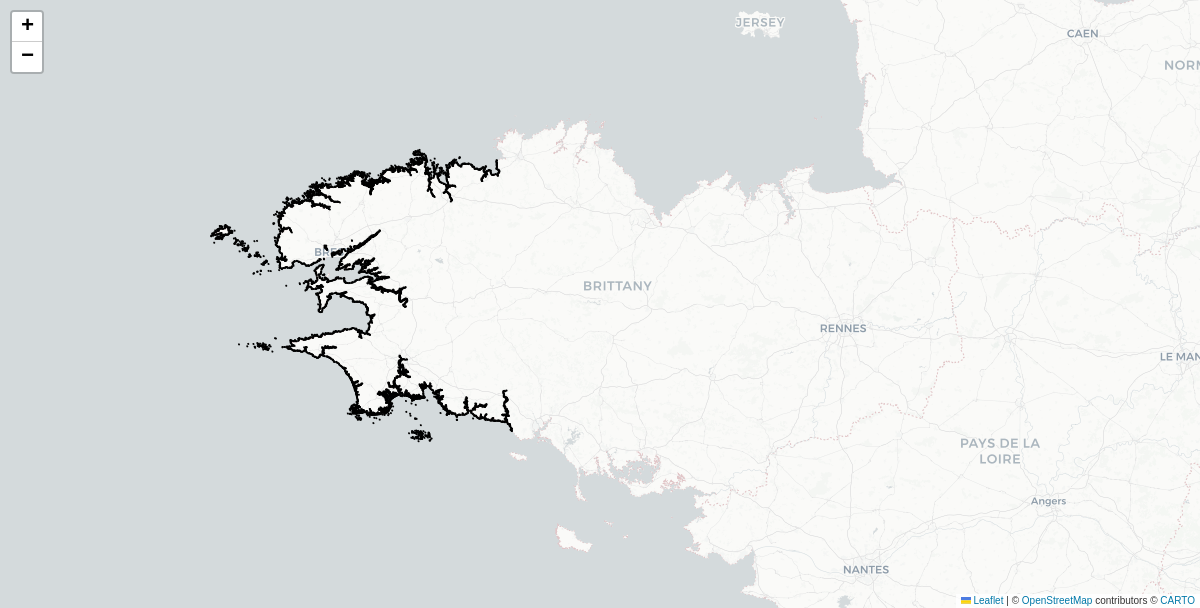

In [ ]:
from IPython.display import display
import folium
import io
import time
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo

def generate_map_from_keywords(keywords, bbox=(-5, 47, -1, 49), zoom_start=8):
    print("Initializing Folium map...")
    brittany_map = folium.Map(location=[48.202, -3.015], zoom_start=zoom_start, tiles="cartodbpositron")
    print("Setting up CSW service...")
    csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
    csw = CatalogueServiceWeb(csw_url)
    query = PropertyIsEqualTo('csw:AnyText', " ".join(keywords))
    csw.getrecords2(constraints=[query], esn='full', maxrecords=10)

    print("Searching for matching WMS layers...")
    wms_url, wms_layer_name = None, None
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WMS':
                wms_url = uri['url']
                wms_layer_name = uri['name']
                print(f"Found WMS URL: {wms_url} with layer: {wms_layer_name}")
                break
        if wms_url:
            break

    if wms_url and wms_layer_name:
        print("Adding WMS layer to the map...")
        folium.raster_layers.WmsTileLayer(
            url=wms_url,
            layers=wms_layer_name,
            fmt="image/png",
            transparent=True,
            version="1.1.1",
            name="GeoBretagne Map Layer",
            overlay=True,
            control=True,
            show=True
        ).add_to(brittany_map)
    else:
        print("No matching WMS services found.")
    return brittany_map

def folium_map_to_image(folium_map):
    html_path = '/content/temp_map.html'  # Absolute path for Colab environments
    print(f"Saving map to HTML at {html_path}...")
    folium_map.save(html_path)

    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--window-size=1200,800")

    try:
        print("Starting Selenium browser...")
        with webdriver.Chrome(options=options) as driver:
            driver.get(f"file://{html_path}")
            print("Waiting for the map to load...")
            time.sleep(3)
            png = driver.get_screenshot_as_png()
            print("Screenshot taken.")
    except Exception as e:
        print(f"Error occurred while capturing the map screenshot: {e}")
        return None

    image = Image.open(io.BytesIO(png))
    print("Converted screenshot to image.")
    return image

keywords = ['hauteur', 'submersion', 'finistère']
print("Generating map with keywords...")
map_display = generate_map_from_keywords(keywords)

if map_display:
    print("Converting map to image...")
    map_image = folium_map_to_image(map_display)
    if map_image:
        # Display the image inline for Jupyter or Colab environments
        display(map_image)  # This should render inline if supported
    else:
        print("Map image could not be generated.")
else:
    print("Map could not be generated.")


Ce code crée une interface Gradio qui :

1. **Prend des mots-clés en entrée** : L’utilisateur saisit un texte avec des mots-clés.
2. **Récupère et filtre les données** : Les mots-clés extraits sont utilisés pour interroger des données géospatiales, qui sont ensuite filtrées et analysées.
3. **Génère une carte et un texte** : En fonction des résultats, le code génère une carte et une réponse en texte.
4. **Affiche les résultats** : Le texte et la carte sont affichés dans l’interface Gradio.


In [ ]:
from PIL import Image
import gradio as gr

# Define the Gradio interface function
def gradio_interface(user_input):
    # Extract keywords and query the WFS
    general_keywords = extract_keywords(user_input)
    internal_data = download_wfs_internal_data(general_keywords, max_features=500)

    # Check if data retrieval was successful
    if internal_data is None:
        return f"Désolé, nous n'avons trouvé aucune donnée correspondant à votre recherche pour '{user_input}'.", None

    # Filter data based on keywords
    filtered_data = filter_data_by_relevant_columns(internal_data, general_keywords)

    if not filtered_data:
        return "Désolé, aucun résultat pertinent n'a été trouvé après le filtrage des données.", None

    # Analyze data and generate a text response
    final_response = analyze_data_with_llm(filtered_data, general_keywords)

    # Generate map based on keywords
    map_display = generate_map_from_keywords(general_keywords)  # Create the map
    map_image = folium_map_to_image(map_display)  # Convert map to image

    # Return response and map image based on their availability
    if isinstance(map_image, Image.Image) and final_response:
        return final_response, map_image
    elif final_response:
        return final_response, None
    elif isinstance(map_image, Image.Image):
        return "", map_image
    else:
        return "Aucun résultat pertinent trouvé.", None

# Gradio UI setup
gradio_ui = gr.Interface(
    fn=gradio_interface,
    inputs="text",
    outputs=["text", "image"],
    title="Identification des Colonnes et Génération de Carte",
    description="Entrez un texte avec des mots-clés pour obtenir les colonnes pertinentes et une carte en fonction des données WFS."
)

# Launch the Gradio app
gradio_ui.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0174f1a313a86d209.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
